In [11]:
import numpy as np
import random
from IPython.display import clear_output
from collections import deque
import progressbar

import gym
import gym_gvgai
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Input, Flatten
from tensorflow.keras.optimizers import Adam

from datetime import datetime
from packaging import version

# Constants

IMG_H = 9
IMG_W = 13
STATE_SIZE = (IMG_H, IMG_W)

PLAYER_TILE_VALUE = 201
SECONDARY_PLAYER_TILE_VALUE = 38

# Tensorboard extension

%load_ext tensorboard
logdir = "logs/scalars/zelda-03"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

class Agent:
    def __init__(self, enviroment):
        
        # Initialize atributes
        self._state_size = STATE_SIZE
        #self._state_size = enviroment.observation_space.n
        self._action_size = enviroment.action_space.n
        
        self.expirience_replay = deque(maxlen=2000)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 1.0
        self.dec_epsilon_rate = 0.0001
        self.min_epsilon = 0.1
        
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.align_target_model()

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def _build_compile_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=STATE_SIZE))
        model.add(Dense(96, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(self._action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
        return model

    def align_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state, use_epsilon_strategy=True):
        if np.random.rand() <= self.epsilon and use_epsilon_strategy:
            self.epsilon = self.epsilon - self.dec_epsilon_rate if self.epsilon > self.min_epsilon else self.min_epsilon
            return enviroment.action_space.sample()
        
        if not use_epsilon_strategy and np.random.rand() <= self.min_epsilon:
            return enviroment.action_space.sample()
            
        tensor_state = tf.convert_to_tensor([state])
        
        q_values = self.q_network.predict(tensor_state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            
            tensor_state = tf.convert_to_tensor([state])
            tensor_next_state = tf.convert_to_tensor([next_state])
            
            q_values = self.q_network.predict(tensor_state)
            
            if terminated:
                q_values[0][action] = reward
            else:
                t = self.target_network.predict(tensor_next_state)
                q_values[0][action] = reward + self.gamma * np.amax(t)
            
            self.q_network.fit(tensor_state, q_values, epochs=1, verbose=0, callbacks=[tensorboard_callback])
            
    def save_model(self, model_name="models/zelda_03_q_network"):
        self.q_network.save(model_name)
        
    def load_model(self, model_path):
        self.q_network = keras.models.load_model(model_path)
        self.align_target_model()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow version:  2.4.1


In [12]:
# Utils

import matplotlib.pyplot as plt
from IPython import display

def show_state(env, step=0, name="", info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis("off")

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def grayToArray(array):
    result = np.zeros((IMG_H, IMG_W))
    for i in range(int(array.shape[0]/10)):
        for j in range(int(array.shape[1]/10)):
            result[i][j] = int(array[10*i+5, 10*j+5])
    return result


def grayConversion(image):
    b = image[..., 0]
    g = image[..., 1]
    r = image[..., 2]
    return 0.21 * r + 0.72 * g + 0.07 * b

def reshape_state(state):
    return grayToArray(grayConversion(state))

In [ ]:
# Train

batch_size = 256
num_of_episodes = 100
timesteps_per_episode = 1000

enviroment = gym.make("gvgai-zelda-lvl0-v0")
agent = Agent(enviroment)
# agent.load_model("models/zelda_03_q_network")
agent.q_network.summary()

In [ ]:
def find_position(state: list, previous_position):
        player_row_index = None
        player_col_index = None

        if previous_position is None or previous_position[0] is None:
            for row_index, row in enumerate(state):
                for col_index, value in enumerate(row):
                    if value == PLAYER_TILE_VALUE or value == SECONDARY_PLAYER_TILE_VALUE:
                        player_row_index = row_index
                        player_col_index = col_index
                        break
                if not (player_row_index is None):
                    break
            return player_row_index, player_col_index

        for row_offset in range(-2, 2, 1):
            for col_offset in range(-2, 2, 1):
                row_index = previous_position[0] + row_offset
                col_index = previous_position[1] + col_offset
                value = int(state[row_index][col_index])

                # print('row_index, col_index, value', row_index, col_index, value)
                if value == PLAYER_TILE_VALUE or value == SECONDARY_PLAYER_TILE_VALUE:
                    player_row_index = row_index
                    player_col_index = col_index
                    break
            if not (player_row_index is None):
                break

        return player_row_index, player_col_index

def process_reward(current_state, next_state, action_id, raw_reward, is_over, info, position, next_position):
        actions_list = ['ACTION_NIL', 'ACTION_USE', 'ACTION_LEFT',
                        'ACTION_RIGHT', 'ACTION_DOWN', 'ACTION_UP']
        action = actions_list[action_id]

        is_winner = info["winner"] != "PLAYER_LOSES" and info["winner"] != "NO_WINNER"

        if is_over and is_winner:
            return 100

        if is_over and not is_winner:
            return -100

        if raw_reward > 0:
            return raw_reward * 10

        if action in ['ACTION_NIL']:
            return -200

        if action in ['ACTION_USE']:
            return -100

        has_moved = next_position[0] != position[0] or next_position[1] != position[1]

        if not has_moved:
            return -5

        return -1

for e in range(0, num_of_episodes):
    # Reset the enviroment
    state = enviroment.reset()
    state = reshape_state(state)
    position = find_position(state, None)
    
    # Initialize variables
    reward = 0
    terminated = False
    
    bar = progressbar.ProgressBar(maxval=timesteps_per_episode/10, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state)
        
        # Take action    
        next_state, reward, terminated, info = enviroment.step(action) 
        next_state = reshape_state(next_state)
        next_position = find_position(next_state, position)
        reward = process_reward(state, next_state, action, reward, terminated, info, position, next_position)
        agent.store(state, action, reward, next_state, terminated)
        
        state = next_state
        position = next_position
        
        if terminated:
            agent.align_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)
        
        if timestep%10 == 0:
            agent.align_target_model()
            bar.update(timestep/10 + 1)
    
    bar.finish()
    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
        print("**********************************")
    agent.save_model("models/zelda_03_q_network_{}".format(e))

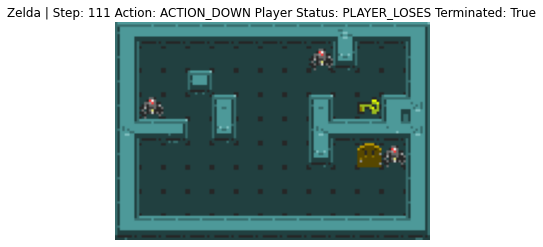

terminated


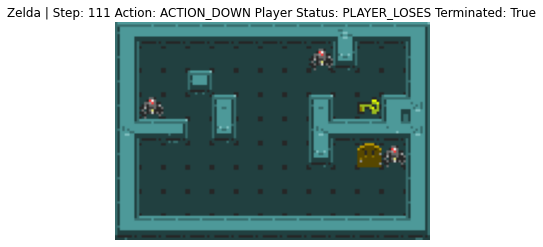

In [15]:
# Play with agent
enviroment = gym.make("gvgai-zelda-lvl0-v0")
actions_list = ['ACTION_NIL', 'ACTION_USE', 'ACTION_LEFT',
                        'ACTION_RIGHT', 'ACTION_DOWN', 'ACTION_UP']
agent = Agent(enviroment)

model_path = "models/zelda_8_q_network_0"
timesteps = 2000

agent.load_model(model_path)
state = reshape_state(enviroment.reset())

for timestep in range(timesteps):
    action = agent.act(state, False)
    
    next_state, reward, terminated, info = enviroment.step(action)
    state = reshape_state(next_state)
    
    print(action, reward, terminated, info)
    show_state(enviroment, timestep, "Zelda", "Action: {} Player Status: {} Terminated: {}".format(actions_list[action], info['winner'], terminated))

    if terminated:
        print("terminated")
        break